# 1. Setup and Get Data

### 1.1 Install 

In [1]:
!pip install labelme tensorflow tensorflow-cpu opencv-python matplotlib albumentations

In [2]:
!python.exe -m pip install --upgrade pip

### 1.2 Collect img using OpenCV

In [3]:
import cv2  # OpenCV
import uuid # Creates unique uniform id
import time
import os

!!! Do not use if you have DATAset (go to the step 2.0)!!!

In [4]:
IMAGES_PATH = os.path.join('data', 'images')
num_imgs = 21

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(num_imgs):
    print('Collecting image', imgnum)
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate images

In [104]:
!labelme

## 2.Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 (Optional) Limite GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [36]:
images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg', shuffle=False)

In [37]:
images.as_numpy_iterator().next()

b'data\\test\\images\\025cd143-04e1-11ee-b530-b06088db1513.jpg'

In [38]:
def load_image(file_path):
    byte_img = tf.io.read_file(file_path)
    return tf.io.decode_jpeg(byte_img) # img

In [39]:
images = images.map(load_image)

In [40]:
images.as_numpy_iterator().next()

array([[[105, 105, 105],
        [104, 104, 104],
        [104, 104, 104],
        ...,
        [102, 107, 103],
        [ 99, 103, 102],
        [ 96, 100,  99]],

       [[105, 105, 105],
        [104, 104, 104],
        [104, 104, 104],
        ...,
        [101, 106, 102],
        [ 99, 103, 102],
        [ 96, 100,  99]],

       [[103, 103, 103],
        [103, 103, 103],
        [103, 103, 103],
        ...,
        [102, 104, 101],
        [101, 103, 102],
        [ 99, 101, 100]],

       ...,

       [[ 35,  37,  36],
        [ 34,  36,  35],
        [ 34,  36,  35],
        ...,
        [210, 204, 208],
        [210, 204, 208],
        [209, 203, 207]],

       [[ 35,  37,  36],
        [ 34,  36,  35],
        [ 35,  37,  36],
        ...,
        [226, 215, 219],
        [226, 216, 217],
        [225, 216, 217]],

       [[ 35,  37,  36],
        [ 34,  36,  35],
        [ 35,  37,  36],
        ...,
        [213, 201, 203],
        [210, 200, 199],
        [210, 200, 199]]

In [41]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()
image_generator

In [15]:
plot_images = image_generator.next()

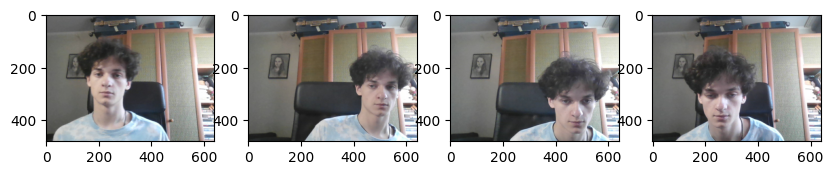

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
# print(ax)
for idx, image in enumerate(plot_images):
    # print(idx,image)
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data


### 3.1 MANUALLY Split Data Into Train, Test, Val


In [17]:
150 *.7 # 105 to train

105.0

In [18]:
150 *.15 # 23/22 to test/val respectively

22.5

### 3.2 Move the Matching Labels

In [21]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## 4. Apply Image Augmentation on Images and Labels using Albumentations


### 4.1 Setup Albumentations Transform Pipeline

In [42]:
import albumentations as alb 

In [43]:
# documentation https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
img = cv2.imread(os.path.join('data', 'test', 'images', '025cd143-04e1-11ee-b530-b06088db1513.jpg'))
img.shape

(480, 640, 3)

In [44]:
augmentor = alb.Compose([alb.RandomCrop(width=460, height=460),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [45]:
with open(os.path.join('data', 'test', 'labels', '025cd143-04e1-11ee-b530-b06088db1513.json'), 'r') as f:
    label = json.load(f)

#### 4.2.1 Test

In [46]:
# Amount of detected objects on the screen
for i in label['shapes']:
    print(i['label'])

face
eyes


In [47]:
label['shapes'][0]['points']

[[152.8125, 350.15625], [325.20833333333337, 124.11458333333331]]

### 4.3 Extract Coordinates and Rescale to Match image Resolutions

In [48]:
obj = dict()
k = 0
for i in label['shapes']:
    coords = [0, 0, 0, 0]
    coords[0] = label['shapes'][k]['points'][0][0]
    coords[1] = label['shapes'][k]['points'][0][1]
    coords[2] = label['shapes'][k]['points'][1][0]
    coords[3] = label['shapes'][k]['points'][1][1]
    k += 1
    if coords[0] > coords[2]:
        coords[0], coords[2] = coords[2], coords[0]
    if coords[1] > coords[3]:
        coords[1], coords[3] = coords[3], coords[1]
    obj[i['label']] = coords
               
    print(obj[i['label']], img.shape)
k = 0

[152.8125, 124.11458333333331, 325.20833333333337, 350.15625] (480, 640, 3)
[177.29166666666669, 206.40625, 293.4375, 251.71875] (480, 640, 3)


In [49]:
for i in obj:
    obj[i] = list(np.divide(obj[i], [640, 480, 640, 480]))
    print(i, obj[i])
print(obj['face'])

face [0.23876953125, 0.25857204861111105, 0.5081380208333334, 0.7294921875]
eyes [0.2770182291666667, 0.4300130208333333, 0.45849609375, 0.5244140625]
[0.23876953125, 0.25857204861111105, 0.5081380208333334, 0.7294921875]


### 4.4 Apply Augmentations and View Results


In [50]:
def calc(augmented, obj):
    x_min = augmented['bboxes'][0][0] / obj['face'][0]
    y_min = augmented['bboxes'][0][1] / obj['face'][1]
    x_max = (augmented['bboxes'][0][2] / obj['face'][2]) * 1.05
    y_max = (augmented['bboxes'][0][3] / obj['face'][3]) * 1.05
    diff = [x_min, y_min, x_max, y_max]
    for i in range(4):
        diff[i] = obj["eyes"][i] * diff[i]
        augmented['bboxes'] = [diff]
    augmented['class_labels'] = ["eyes"]
    return augmented

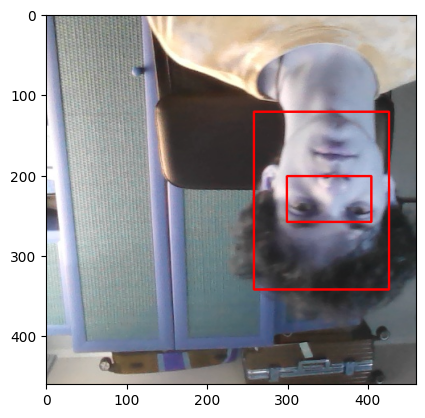

In [51]:
augmented = augmentor(image=img, bboxes=[obj["face"]], class_labels=["face"])

cv2.rectangle(augmented['image'], 
    tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)
if len(obj) > 1:
    augmented = calc(augmented, obj)
    cv2.rectangle(augmented['image'], 
        tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
        tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                        (255,0,0), 2)
#BGR to RGB
plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline


### 5.1 Run Augmentation Pipeline

In [52]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            if coords[0] > coords[2]:
                coords[0], coords[2] = coords[2], coords[0]
            if coords[1] > coords[3]:
                coords[1], coords[3] = coords[3], coords[1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [53]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [54]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [55]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [56]:
train_images.as_numpy_iterator().next()

array([[[0.5010076 , 0.5010076 , 0.5010076 ],
        [0.5007353 , 0.5007353 , 0.5085784 ],
        [0.50574625, 0.50574625, 0.5135894 ],
        ...,
        [0.73744553, 0.7673203 , 0.78357846],
        [0.7281046 , 0.7633987 , 0.78300655],
        [0.7238562 , 0.7591503 , 0.78333336]],

       [[0.4884804 , 0.4884804 , 0.49387255],
        [0.4882353 , 0.4882353 , 0.4897059 ],
        [0.49648696, 0.49648696, 0.49648696],
        ...,
        [0.73333335, 0.7607843 , 0.7844771 ],
        [0.71838236, 0.7536765 , 0.7732843 ],
        [0.7137255 , 0.74419945, 0.7647877 ]],

       [[0.48986927, 0.48986927, 0.4977124 ],
        [0.48986927, 0.48986927, 0.48986927],
        [0.4859477 , 0.4859477 , 0.4859477 ],
        ...,
        [0.725817  , 0.7538671 , 0.78428656],
        [0.71838236, 0.74583334, 0.76936275],
        [0.7027505 , 0.7272606 , 0.7411222 ]],

       ...,

       [[0.80836046, 0.8436546 , 0.86364377],
        [0.80604565, 0.8415032 , 0.86102927],
        [0.76075715, 0

## 6 Prepare Labels

### 6.1 Build Label Loading Function

In [57]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox'] # returning annotation 

### 6.2 Load Labels to Tensorflow Dataset


In [58]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [59]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7200, 7200, 1560, 1560, 1500, 1500)

### 7.2 Create Final Datasets (Images/Labels)

In [37]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(10000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [38]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.3386 , 0.2756 , 0.7324 ],
        [0.     , 0.1909 , 0.1492 , 0.6587 ],
        [0.05276, 0.1092 , 0.501  , 0.6777 ],
        [0.4272 , 0.3904 , 0.7476 , 0.755  ],
        [0.1998 , 0.5728 , 0.4512 , 0.824  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3193 , 0.2068 , 0.862  , 0.9    ],
        [0.7754 , 0.3503 , 1.     , 0.733  ]], dtype=float16))

## 7.3 View Images and Annotations

In [43]:
data_samples = train.as_numpy_iterator()
print(data_samples)

In [50]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


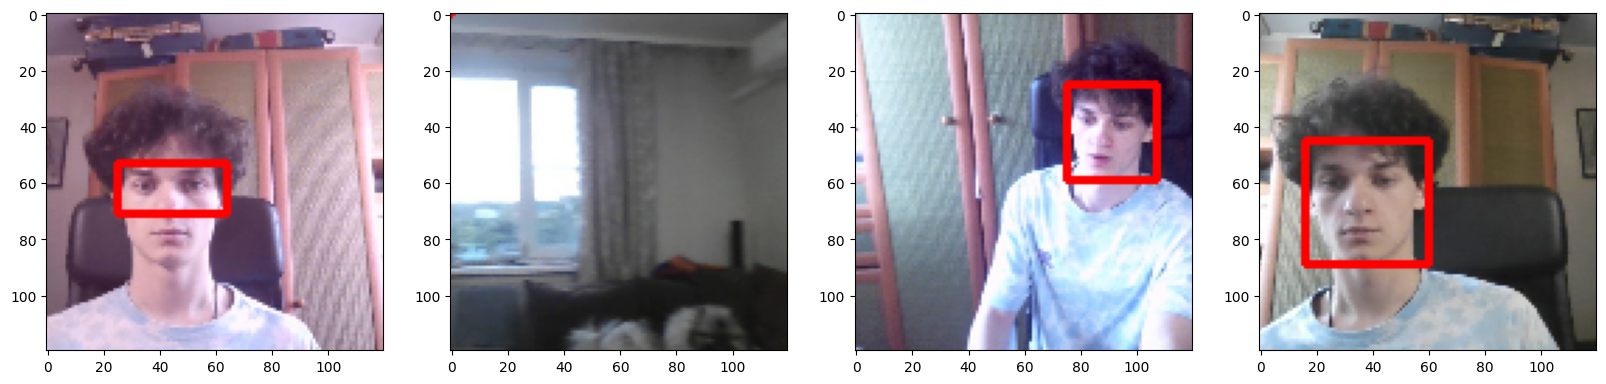

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network


In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16


In [53]:
vgg = VGG16(include_top=False) # We don't need last classification layers

In [54]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build Instance of Network

In [55]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [56]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.436 , 0.1519, 0.8516],
        [0.    , 0.355 , 0.4468, 0.9233],
        [0.1517, 0.637 , 0.3545, 0.886 ],
        [0.428 , 0.4158, 0.734 , 0.77  ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 8.4 Test out Neural Network

In [57]:
facetracker = build_model()

In [58]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [59]:
X, y = train.as_numpy_iterator().next() # x - images; y - labels

In [60]:
X.shape

(8, 120, 120, 3)

In [61]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 637ms/step


In [62]:
classes, coords

(array([[0.5222052 ],
        [0.4999791 ],
        [0.6009858 ],
        [0.57052225],
        [0.5444084 ],
        [0.5864777 ],
        [0.48552182],
        [0.3978421 ]], dtype=float32),
 array([[0.35543764, 0.4398296 , 0.34793097, 0.7401672 ],
        [0.39508802, 0.55024576, 0.32010102, 0.7022222 ],
        [0.36442462, 0.4919001 , 0.39180073, 0.74399734],
        [0.398108  , 0.4927833 , 0.3566411 , 0.7364001 ],
        [0.33578846, 0.53304595, 0.3666546 , 0.7309111 ],
        [0.42083836, 0.50568384, 0.43034348, 0.6900041 ],
        [0.3297053 , 0.44676757, 0.37633222, 0.7783251 ],
        [0.31992093, 0.37333444, 0.3865071 , 0.75475204]], dtype=float32))

## 9. Define Losses and Optimizers


### 9.1 Define Optimizer and LR

In [63]:
len(train)

900

In [64]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [65]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [66]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [67]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [68]:
localization_loss(y[1], coords).numpy()

1.6431543

In [69]:
classloss(y[0], classes).numpy()

0.6498971

In [70]:
regressloss(y[1], coords).numpy()

1.6431543

# 10. Train Neural Network


### 10.1 Create Custom Model Class

In [71]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs):
        
        # Unpacking batch into the x, y
        X, y = batch
        
        # Telling keras to start calculating each of diff functions
        with tf.GradientTape() as tape: 
            # Making a prediction
            classes, coords = self.model(X, training=True)
            
            # Pass to loss funct (y[0] - y true; classes - y pred)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # My prediction of 0.5*batch_classloss (can be changed)
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            # Calculate gradient
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        # Gradient descent 
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        # Done this to see the progress
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    # def call(self, X, **kwargs): 
    #     return self.model(X, **kwargs)

In [72]:
model = FaceTracker(facetracker)


In [73]:
model.compile(opt, classloss, regressloss)


### 10.2 Train

In [74]:
logdir='logs'

In [75]:
# Optional as a reserv
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [87]:
hist = model.fit(train, epochs=8, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
900/900 [==============================] - 3976s 4s/step - total_loss: 0.0489 - class_loss: 0.0079 - regress_loss: 0.0449 - val_total_loss: 1.3497 - val_class_loss: 1.2655 - val_regress_loss: 0.7169
Epoch 2/8
900/900 [==============================] - 4363s 5s/step - total_loss: 0.0255 - class_loss: 0.0034 - regress_loss: 0.0238 - val_total_loss: 0.0076 - val_class_loss: 0.0049 - val_regress_loss: 0.0051
Epoch 3/8
900/900 [==============================] - 4280s 5s/step - total_loss: 0.0192 - class_loss: 0.0027 - regress_loss: 0.0178 - val_total_loss: 0.0074 - val_class_loss: 4.4388e-04 - val_regress_loss: 0.0072
Epoch 4/8
900/900 [==============================] - 4314s 5s/step - total_loss: 0.0145 - class_loss: 0.0011 - regress_loss: 0.0140 - val_total_loss: 0.0080 - val_class_loss: 4.2320e-06 - val_regress_loss: 0.0080
Epoch 5/8
900/900 [==============================] - 4298s 5s/step - total_loss: 0.0142 - class_loss: 0.0014 - regress_loss: 0.0135 - val_total_loss: 0.0942

### 10.3 Train

In [88]:
hist.history

{'total_loss': [0.010331924073398113,
  0.011552124284207821,
  0.006554483436048031,
  0.009424320422112942,
  0.00705645652487874,
  0.003736508544534445,
  0.006197486072778702,
  0.002142758574336767],
 'class_loss': [0.00010836966976057738,
  8.367056580027565e-06,
  0.001558034447953105,
  0.0018894040258601308,
  0.00017676960851531476,
  1.2167032764409669e-05,
  6.936168210813776e-05,
  9.343169949715957e-06],
 'regress_loss': [0.01027773879468441,
  0.011547940783202648,
  0.0057754660956561565,
  0.008479618467390537,
  0.006968071684241295,
  0.003730424912646413,
  0.006162805017083883,
  0.002138087060302496],
 'val_total_loss': [1.349682331085205,
  0.0075817531906068325,
  0.0074405670166015625,
  0.008012410253286362,
  0.09424981474876404,
  0.3021564185619354,
  0.07280251383781433,
  0.014519667252898216],
 'val_class_loss': [1.2655177116394043,
  0.004865425638854504,
  0.00044387567322701216,
  4.231959337630542e-06,
  1.075879845302552e-05,
  0.2639634609222412,


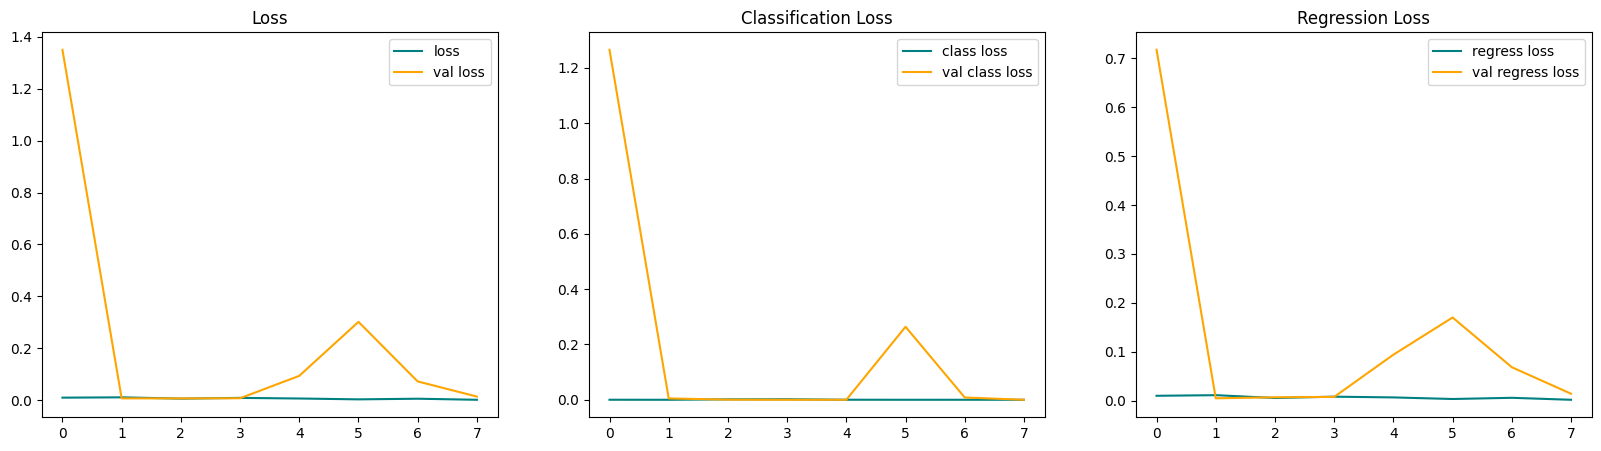

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11.2 Save the Model

In [90]:
from tensorflow.keras.models import load_model

In [91]:
facetracker.save('facetracker.h5')

In [92]:
facetracker = load_model('facetracker.h5')

In [93]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 339ms/step
